In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [161]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5}

In [162]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [163]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [212]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    first_duration = 750 #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

Mean decision time is  67.98333333333333


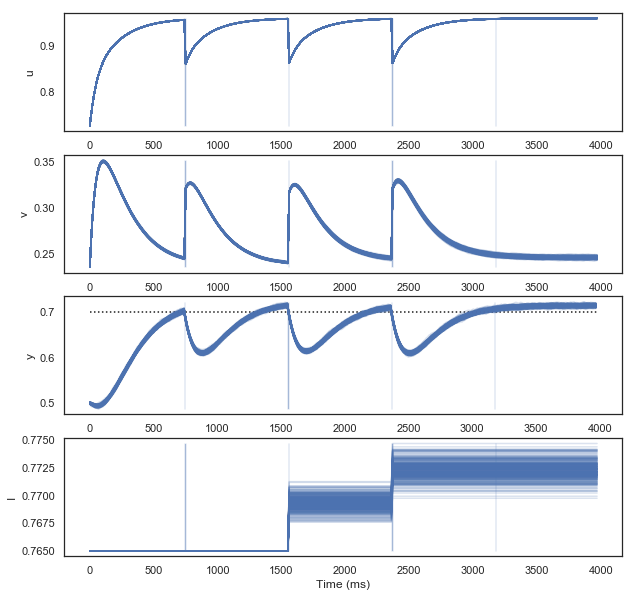

In [175]:
sigma = 0.01
K = 3.07
I = 0.765
duration = 800

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data012619_K3_164_I0_7825_s0_0136_1000ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a single ISI

In [ ]:
#TODO: function to find I that hits the correct interval in 1 iteration..(?)

In [8]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

duration = 600

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, 
                                                               duration=duration, sigma=sigma, K=K, initI=0.84)
        times = get_times_lst_from_y(np.array(ylst2))
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263
Working on K =  2.1052631578947367
Working on K =  2.3157894736842106
Working on K =  2.526315789473684
Working on K =  2.7368421052631575
Working on K =  2.9473684210526314
Working on K =  3.1578947368421053
Working on K =  3.3684210526315788
Working on K =  3.578947368421052
Working on K =  3.789473684210526
Working on K =  4.0
Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263


Text(0, 0.5, '$\\sigma$')

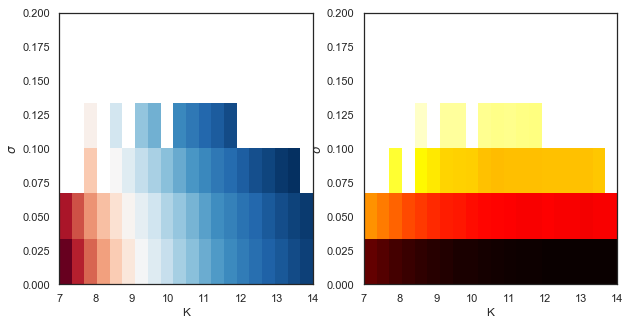

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

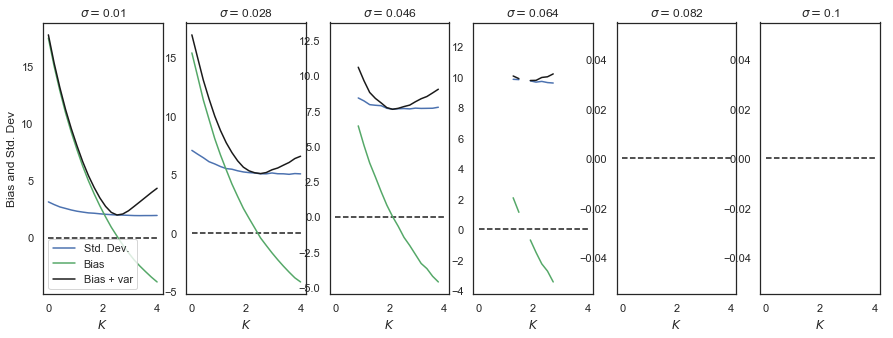

In [10]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    #ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


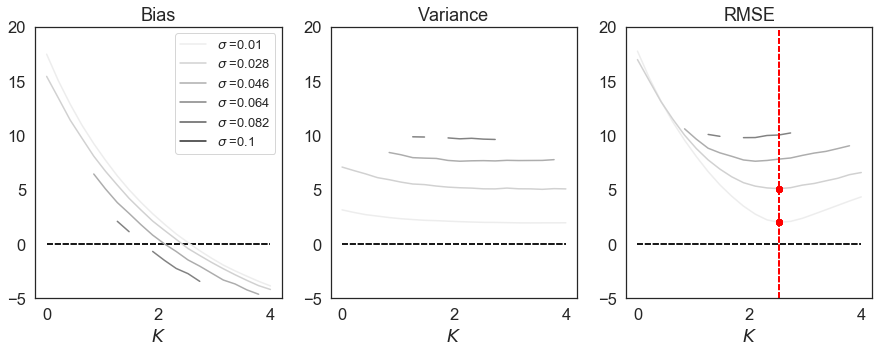

In [11]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [30]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.03, 6)

nK = 10
nI = 10
Klst = np.linspace(2, 3.5, nK)
initIlst = np.linspace(0.83, 0.86, nI)
MSELST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, dur in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
    MSELST.append(mse_lst)
    

*** sigma =  0.005  ***
I =  0.83 K =  2.0 Total MSE =  13747.465220905271
I =  0.83 K =  2.1666666666666665 Total MSE =  13247.067600038885
I =  0.83 K =  2.3333333333333335 Total MSE =  12741.153793907364
I =  0.83 K =  2.5 Total MSE =  12228.691671638468
I =  0.83 K =  2.6666666666666665 Total MSE =  11720.878806642444
I =  0.83 K =  2.833333333333333 Total MSE =  11177.338681457228
I =  0.83 K =  3.0 Total MSE =  10682.017599685933
I =  0.83 K =  3.1666666666666665 Total MSE =  10132.285033495653
I =  0.83 K =  3.333333333333333 Total MSE =  9613.396902240123
I =  0.83 K =  3.5 Total MSE =  9026.173053958139
I =  0.8333333333333333 K =  2.0 Total MSE =  12095.015502263732
I =  0.8333333333333333 K =  2.1666666666666665 Total MSE =  11680.958864750788
I =  0.8333333333333333 K =  2.3333333333333335 Total MSE =  11266.35255972402
I =  0.8333333333333333 K =  2.5 Total MSE =  10886.872829237971
I =  0.8333333333333333 K =  2.6666666666666665 Total MSE =  10439.516272318368
I =  0.8333

I =  0.8366666666666667 K =  2.1666666666666665 Total MSE =  10355.457498343567
I =  0.8366666666666667 K =  2.3333333333333335 Total MSE =  10097.375896736736
I =  0.8366666666666667 K =  2.5 Total MSE =  9837.367534050967
I =  0.8366666666666667 K =  2.6666666666666665 Total MSE =  9538.652944729669
I =  0.8366666666666667 K =  2.833333333333333 Total MSE =  9137.237000319079
I =  0.8366666666666667 K =  3.0 Total MSE =  8884.835395211327
I =  0.8366666666666667 K =  3.1666666666666665 Total MSE =  8522.44683174967
I =  0.8366666666666667 K =  3.333333333333333 Total MSE =  8257.366408244217
I =  0.8366666666666667 K =  3.5 Total MSE =  7988.316468443148
I =  0.84 K =  2.0 Total MSE =  9090.434533068263
I =  0.84 K =  2.1666666666666665 Total MSE =  8983.779828112441
I =  0.84 K =  2.3333333333333335 Total MSE =  8750.337136362234
I =  0.84 K =  2.5 Total MSE =  8570.840098846787
I =  0.84 K =  2.6666666666666665 Total MSE =  8425.354591944484
I =  0.84 K =  2.833333333333333 Total M

I =  0.8433333333333333 K =  2.5 Total MSE =  8294.40172646587
I =  0.8433333333333333 K =  2.6666666666666665 Total MSE =  8118.65136583657
I =  0.8433333333333333 K =  2.833333333333333 Total MSE =  8123.0597683385295
I =  0.8433333333333333 K =  3.0 Total MSE =  7951.69793188851
I =  0.8433333333333333 K =  3.1666666666666665 Total MSE =  7804.178368028245
I =  0.8433333333333333 K =  3.333333333333333 Total MSE =  7724.35110543274
I =  0.8433333333333333 K =  3.5 Total MSE =  7605.031229390186
I =  0.8466666666666667 K =  2.0 Total MSE =  8242.469290206667
I =  0.8466666666666667 K =  2.1666666666666665 Total MSE =  8080.67447679957
I =  0.8466666666666667 K =  2.3333333333333335 Total MSE =  7872.909246269767
I =  0.8466666666666667 K =  2.5 Total MSE =  7702.356782180374
I =  0.8466666666666667 K =  2.6666666666666665 Total MSE =  7566.696769396802
I =  0.8466666666666667 K =  2.833333333333333 Total MSE =  7446.07950535045
I =  0.8466666666666667 K =  3.0 Total MSE =  7236.71886

I =  0.85 K =  2.6666666666666665 Total MSE =  8123.786063160453
I =  0.85 K =  2.833333333333333 Total MSE =  8091.853928488823
I =  0.85 K =  3.0 Total MSE =  7881.992133972223
I =  0.85 K =  3.1666666666666665 Total MSE =  8013.800596471066
I =  0.85 K =  3.333333333333333 Total MSE =  7949.521998208445
I =  0.85 K =  3.5 Total MSE =  7904.6189028946865
I =  0.8533333333333333 K =  2.0 Total MSE =  11161.482876392365
I =  0.8533333333333333 K =  2.1666666666666665 Total MSE =  10204.293214132962
I =  0.8533333333333333 K =  2.3333333333333335 Total MSE =  9421.735508917664
I =  0.8533333333333333 K =  2.5 Total MSE =  8766.019621242014
I =  0.8533333333333333 K =  2.6666666666666665 Total MSE =  8407.068454580349
I =  0.8533333333333333 K =  2.833333333333333 Total MSE =  8208.501690320834
I =  0.8533333333333333 K =  3.0 Total MSE =  7951.572171589716
I =  0.8533333333333333 K =  3.1666666666666665 Total MSE =  7736.34926822723
I =  0.8533333333333333 K =  3.333333333333333 Total M

I =  0.8566666666666667 K =  2.833333333333333 Total MSE =  9324.355205589285
I =  0.8566666666666667 K =  3.0 Total MSE =  9110.0
I =  0.8566666666666667 K =  3.1666666666666665 Total MSE =  8673.148217342996
I =  0.8566666666666667 K =  3.333333333333333 Total MSE =  8608.925600793633
I =  0.8566666666666667 K =  3.5 Total MSE =  8683.357645519387
I =  0.86 K =  2.0 Total MSE =  16654.720051685046
I =  0.86 K =  2.1666666666666665 Total MSE =  14851.680039645347
I =  0.86 K =  2.3333333333333335 Total MSE =  13150.813663040017
I =  0.86 K =  2.5 Total MSE =  11848.096893594346
I =  0.86 K =  2.6666666666666665 Total MSE =  10394.233978509432
I =  0.86 K =  2.833333333333333 Total MSE =  9815.533607501937
I =  0.86 K =  3.0 Total MSE =  9287.911498286361
I =  0.86 K =  3.1666666666666665 Total MSE =  8848.06758563699
I =  0.86 K =  3.333333333333333 Total MSE =  8532.637341408576
I =  0.86 K =  3.5 Total MSE =  8568.774708206536
*** sigma =  0.03  ***
I =  0.83 K =  2.0 Total MSE =  1

In [153]:
scipy.io.savemat('PlotTools/IK_relationship_sigma_0-02_102918_1000trials.mat', {'MSELST': MSELST,
                                                          'Klst': Klst,
                                                          'Ilst': initIlst})

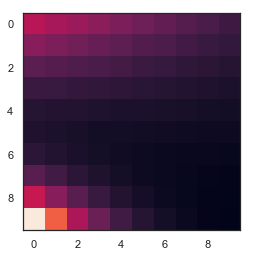

In [33]:
plt.imshow(MSELST[1])

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [176]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 10)

nsamples = 100
nstages = 8
MSELST = []

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=3.5, size=nsamples)
        initIlst = np.random.uniform(low=0.75, high=0.78, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = initIlst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = initIlst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'initIlst': initIlst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  3.2736723119140403 , Imin = 0.7771364443483809
    Running iteration # 1
        Kmin =  2.392833471608541 , Imin = 0.779219651209259
    Running iteration # 2
        Kmin =  3.3851272956396143 , Imin = 0.7775872651191978
*** sigma =  0.011111111111111112  ***
    Running iteration # 0
        Kmin =  1.9879531004073598 , Imin = 0.7798075875957434
    Running iteration # 1
        Kmin =  2.26445435795722 , Imin = 0.7766449844144084
    Running iteration # 2
        Kmin =  2.611886987418726 , Imin = 0.7799614794497467
*** sigma =  0.017222222222222222  ***
    Running iteration # 0
        Kmin =  3.353959897625855 , Imin = 0.7698532395839949
    Running iteration # 1
        Kmin =  3.097362977781086 , Imin = 0.7774748890561275
    Running iteration # 2
        Kmin =  2.1962845810365645 , Imin = 0.7781481899296402
*** sigma =  0.023333333333333334  ***
    Running iteration # 0
        Kmin =  2.074449211852535 , Imi

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

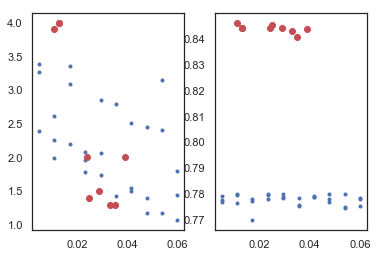

In [177]:
# Behavioral results
#sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
#I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
#K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

# Params fit with threshold = 0.7
#sigma_behavior = [0.009, 0.018, 0.023, 0.007, 0.021, 0.009, 0.020, 0.025, 0.027];
#I_behavior = [0.781, 0.780, 0.780, 0.782, 0.781, 0.782, 0.781, 0.779, 0.777];
#K_behavior = [2.55, 1.10, 1.28, 2.76, 1.65, 2.89, 0.78, 0.67, 0.75];


# Params fit with threshold = 0.6
#sigma_behavior = [0.015, 0.026, 0.032, 0.012, 0.030, 0.013, 0.025, 0.035, 0.036];
#I_behavior = [0.848, 0.845, 0.844, 0.849, 0.845, 0.847, 0.845, 0.844, 0.841];
#K_behavior = [2.6, 1.0, 1.0, 2.7, 0.9, 2.7, 0.7, 0.7, 0.7];

# Fit with new model (with initial stage constant time)
sigma_behavior = [0.013, 0.024, 0.039, 0.011, 0.029, 0.013, 0.025, 0.033, 0.035];
I_behavior = [0.844, 0.844, 0.8435, 0.846, 0.844, 0.844, 0.845, 0.843, 0.8405];
K_behavior = [4.0, 2.0, 2.0, 3.9, 1.5, 4.0, 1.4, 1.3, 1.3];

plt.subplot(121)

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
    
plt.plot(sigma_behavior, K_behavior, 'or')


plt.subplot('122')
plt.plot(sigma_behavior, I_behavior, 'or')

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
    


In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [40]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
RSG results:
Observed mean STD =  87.07974589531368
Simulated mean STD =  57.00615737808427
RSSG results:
Observed mean STD =  80.59116410512839
Simulated mean STD =  58.26474043622092


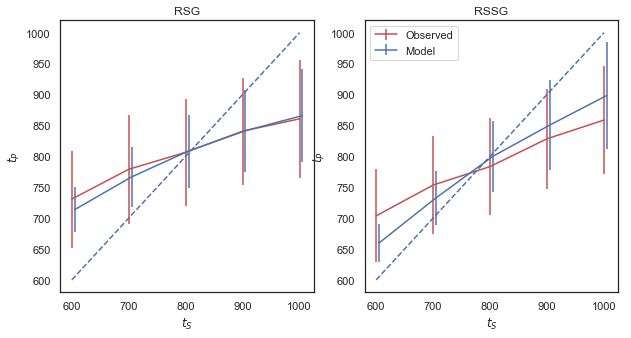

In [234]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = 'CV_EKF_ObsAct0_20171105.mat'

sigma_val = 0.01
I_val = 0.778
K_val = 3.09

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

## Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

### $(I,K)$ fitting

In [233]:
# Fitting the data to find (I, K)
nsamples = 100
sigmaval = 0.01
Klst = np.random.uniform(low=1, high=3.5, size=nsamples)
initIlst = np.random.uniform(low=0.75, high=0.78, size=nsamples)

# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('SWE_EKF_ObsAct0_20171125.mat')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

target_time1 = mtp_in[:,0]
target_time2 = mtp_in[:,1]

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss
errorlst = []

for k in range(nsamples):
    Ival = initIlst[k]
    Kval = Klst[k]
    
    prod_time_lst = []
    prod_var_lst = []
    prod_time_lst2 = []
    prod_var_lst2 = []
    

    #1,2,Go simulation
    for i, time in enumerate(durations):
        #print('Doing time #', i, '=', time)

        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=3, duration=time, 
                                                               sigma=sigmaval, K=Kval, initI=Ival)

        Ylst2 = np.array(ylst2)
        times = get_times_lst_from_y(np.array(Ylst2))
        times = times[(times > 0) & (times != np.inf)]
        #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
        #print('Mean decision time is ', np.mean(times))
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, time in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=time, 
                             sigma=sigmaval, K=Kval, initI=Ival)
        #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
        #print('Mean decision time is ', np.mean(times))
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))
        
    # We want to minimize
    error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) + \
            np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
    errorlst.append(error)
    
    print('I = %f, K = %f, error = %f' %(Ival, Kval, error))
    
    #print('RSG results:')
    #print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
    #print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

    #print('RSSG results:')
    #print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
    #print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

I = 0.754655, K = 2.391232, error = 675799.160827
I = 0.765940, K = 2.426938, error = 289488.805039
I = 0.758040, K = 2.939930, error = 488735.358487
I = 0.753163, K = 2.646047, error = 687114.605558
I = 0.763309, K = 2.314258, error = 388733.966932
I = 0.778468, K = 1.390706, error = 62167.094298
I = 0.770614, K = 1.981549, error = 179476.925743
I = 0.755849, K = 3.139205, error = 517510.828237
I = 0.753635, K = 3.273627, error = 562650.395349
I = 0.763028, K = 1.603652, error = 483171.922417
I = 0.778086, K = 1.486739, error = 50925.093721
I = 0.769319, K = 1.807410, error = 228693.512438
I = 0.771834, K = 1.891551, error = 150034.744864
I = 0.774835, K = 1.502892, error = 87800.041964
I = 0.757177, K = 2.683080, error = 552785.401647
I = 0.779304, K = 1.506870, error = 63069.420740
I = 0.772496, K = 1.259919, error = 168676.235732
I = 0.762856, K = 2.388428, error = 393690.211407
I = 0.775948, K = 2.884349, error = 36413.753628
I = 0.772223, K = 1.524433, error = 154781.855731
I = 0

In [205]:
np.argmin(errorlst)

33

In [206]:
initIlst[33]

0.777764260652297

In [207]:
Klst[33]

3.393299519810872

In [195]:
errorlst[18]

5108633.967568338

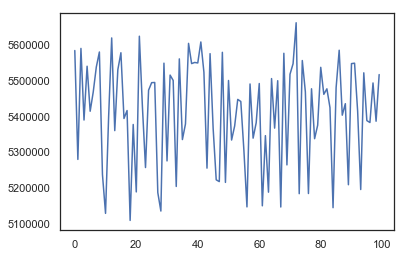

In [196]:
plt.plot(errorlst)

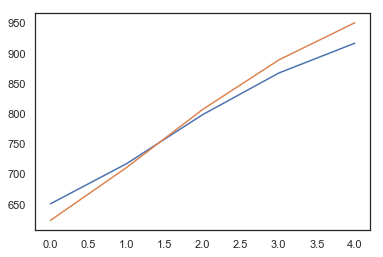

In [198]:
plt.plot(target_time1)
plt.plot(target_time2)

In [203]:
np.array(prod_time_lst) * 10 - target_time1

array([150.89842516, 113.26335691,  48.79038079,  -7.68624682,
       -51.13783846])

array([650.70157484, 717.15664309, 798.36961921, 867.27624682,
       916.78783846])

In [225]:
def do_IK_fitting(subject_file, sigmaval, nsamples=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''

    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    initIlst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = initIlst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Error function to minimize
        error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) + \
                np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, error = %f' %(Ival, Kval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', initIlst[idx], Klst[idx])
    return initIlst[idx], Klst[idx]

In [226]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples=100, low=0.001, high=0.05, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Error function to minimize
        error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) + \
                np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    sigma = %f, error = %f' %(sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx])
    return sigmalst[idx]

In [228]:
def subject_fitting(subject_file, sigma_init=0.02, nsamples=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78, 
                    sigmalow=0.005, sigmahigh=0.04, print_every=10, niter=5):
    '''Optimize for the given subject file,
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, 
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples, 
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [235]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat']

combi_collection = []
for subject_file in all_subject_files:
    print(' ********* Doing subject file %s ************' % subject_file)
    combi = subject_fitting(subject_file)
    combi_collection.append(combi)

 ********* Doing subject file SWE_EKF_ObsAct0_20171105.mat ************
    I = 0.758046, K = 1.231400, error = 751774.061700
    I = 0.753007, K = 2.130721, error = 799701.977012
    I = 0.752622, K = 1.819926, error = 869960.595927
    I = 0.773300, K = 3.440322, error = 92340.983529
    I = 0.752671, K = 3.187654, error = 617090.824737
    I = 0.772977, K = 1.707024, error = 157432.681895
    I = 0.776155, K = 2.098584, error = 65378.140258
    I = 0.764004, K = 3.270582, error = 309982.846075
    I = 0.750149, K = 3.342298, error = 667392.953921
    I = 0.756961, K = 1.481768, error = 750267.051701
Optimal (I, K) =  0.7789010912529892 3.412527854110364
    sigma = 0.005000, error = 7743.200415
    sigma = 0.008535, error = 1724.390769
    sigma = 0.012071, error = 1353.180275
    sigma = 0.015606, error = 8009.637170
    sigma = 0.019141, error = 12695.465865
    sigma = 0.022677, error = 24534.578927
    sigma = 0.026212, error = 22726.677371
    sigma = 0.029747, error = 36556.19

    sigma = 0.012071, error = 3061.954346
    sigma = 0.015606, error = 1972.353758
    sigma = 0.019141, error = 2859.004818
    sigma = 0.022677, error = 6172.468768
    sigma = 0.026212, error = 7993.986030
    sigma = 0.029747, error = 16176.415325
    sigma = 0.033283, error = 12577.450980
    sigma = 0.036818, error = 16432.654240
Optimal sigma =  0.01560606060606061
    I = 0.751288, K = 1.877113, error = 835732.372300
    I = 0.774723, K = 2.623253, error = 35206.417930
    I = 0.752524, K = 3.071867, error = 588788.468449
    I = 0.762431, K = 2.510688, error = 351773.619267
    I = 0.764705, K = 3.381809, error = 224790.176924
    I = 0.776191, K = 2.773835, error = 14259.246308
    I = 0.763818, K = 1.589152, error = 391720.101732
    I = 0.750277, K = 1.996311, error = 843843.622218
    I = 0.773530, K = 3.304090, error = 45671.001892
    I = 0.773809, K = 3.178482, error = 43007.461404
Optimal (I, K) =  0.7786929028127558 2.6182129279043282
    sigma = 0.005000, error = 26

    I = 0.759486, K = 3.228885, error = 510058.653355
    I = 0.759795, K = 1.911205, error = 679965.277134
    I = 0.753269, K = 3.318416, error = 685742.536953
    I = 0.764924, K = 1.253625, error = 564964.937516
Optimal (I, K) =  0.7793450928099409 3.3879436930608398
    sigma = 0.005000, error = 3572.007085
    sigma = 0.008535, error = 1705.315788
    sigma = 0.012071, error = 6175.332212
    sigma = 0.015606, error = 10640.475465
    sigma = 0.019141, error = 22217.848909
    sigma = 0.022677, error = 35393.864985
    sigma = 0.026212, error = 36274.985449
    sigma = 0.029747, error = 47264.487783
    sigma = 0.033283, error = 64020.509093
    sigma = 0.036818, error = 60741.107619
Optimal sigma =  0.008181818181818182
    I = 0.779023, K = 2.988252, error = 30163.724820
    I = 0.778833, K = 1.970221, error = 54354.208144
    I = 0.752420, K = 2.711252, error = 804889.854161
    I = 0.760629, K = 1.350358, error = 715695.314515
    I = 0.758500, K = 2.039123, error = 702652.75

    I = 0.761179, K = 2.019336, error = 476323.613437
    I = 0.750616, K = 1.858969, error = 901632.842482
    I = 0.775921, K = 2.804162, error = 33773.996242
    I = 0.752497, K = 1.817119, error = 834630.117633
    I = 0.752234, K = 1.369277, error = 924383.484858
    I = 0.769808, K = 2.536377, error = 163788.689269
    I = 0.773567, K = 2.621232, error = 79660.917509
    I = 0.778170, K = 2.843987, error = 13198.363634
    I = 0.755616, K = 1.001478, error = 838452.334005
    I = 0.778569, K = 2.537267, error = 7335.657896
Optimal (I, K) =  0.7786015787636297 2.013495114178382
    sigma = 0.005000, error = 37708.196297
    sigma = 0.008535, error = 18047.843203
    sigma = 0.012071, error = 8323.721577
    sigma = 0.015606, error = 3300.605460
    sigma = 0.019141, error = 1641.073068
    sigma = 0.022677, error = 1514.385430
    sigma = 0.026212, error = 1494.864076
    sigma = 0.029747, error = 7587.570657
    sigma = 0.033283, error = 7809.760565
    sigma = 0.036818, error = 

    sigma = 0.012071, error = 4380.228492
    sigma = 0.015606, error = 2180.176971
    sigma = 0.019141, error = 1085.789418
    sigma = 0.022677, error = 3626.099690
    sigma = 0.026212, error = 3920.295936
    sigma = 0.029747, error = 9647.166674
    sigma = 0.033283, error = 8131.225941
    sigma = 0.036818, error = 16062.241409
Optimal sigma =  0.017020202020202022
    I = 0.753792, K = 1.961936, error = 907585.597385
    I = 0.768416, K = 1.435127, error = 342290.543538
    I = 0.762162, K = 3.006283, error = 435801.495985
    I = 0.765256, K = 2.235928, error = 404390.069456
    I = 0.777877, K = 1.384220, error = 14816.611580
    I = 0.751063, K = 1.918644, error = 1011668.801509
    I = 0.775465, K = 1.275331, error = 78650.099301
    I = 0.755221, K = 2.239349, error = 795040.835104
    I = 0.750930, K = 3.472770, error = 726208.695315
    I = 0.776939, K = 1.747736, error = 36118.332029
Optimal (I, K) =  0.7796984268833896 1.377093781493506
    sigma = 0.005000, error = 25

    I = 0.773609, K = 2.771515, error = 61233.857538
    I = 0.753176, K = 2.237455, error = 628006.149596
    I = 0.750812, K = 1.958480, error = 765223.903690
Optimal (I, K) =  0.7798216749084719 2.961402427453046
    sigma = 0.005000, error = 38991.858225
    sigma = 0.008535, error = 21531.837215
    sigma = 0.012071, error = 9699.944423
    sigma = 0.015606, error = 6471.780553
    sigma = 0.019141, error = 7970.591702
    sigma = 0.022677, error = 8609.693953
    sigma = 0.026212, error = 12789.597655
    sigma = 0.029747, error = 17251.791836
    sigma = 0.033283, error = 14211.374569
    sigma = 0.036818, error = 16885.511712
Optimal sigma =  0.021969696969696972
    I = 0.776283, K = 1.602960, error = 11138.234488
    I = 0.775823, K = 1.685805, error = 18456.634249
    I = 0.758410, K = 2.097789, error = 465021.533797
    I = 0.751774, K = 1.122621, error = 851641.133427
    I = 0.762263, K = 3.386503, error = 245233.887505
    I = 0.779549, K = 1.556337, error = 7685.604623


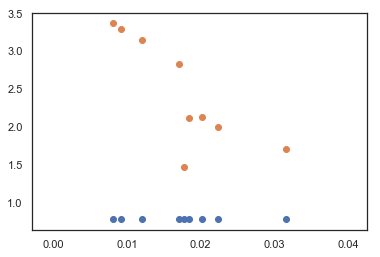

In [240]:
# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]

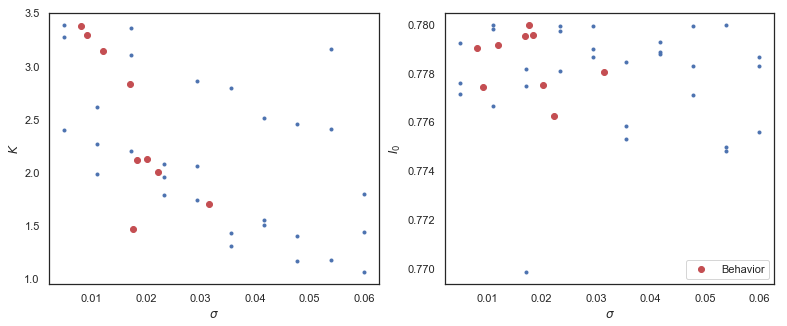

In [251]:
plt.figure(figsize=(13,5))
plt.subplot(121)
# Simulation
for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
# Behavior
plt.plot(sigmas, Karr, 'or')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')

plt.subplot('122')
# Simulation
for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
# Behavior
plt.plot(sigmas, Iarr, 'or', label='Behavior')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I_0$')
plt.legend()

plt.savefig('KI_relationship.pdf')

In [252]:
combi_arr

array([[0.01207071, 0.77913666, 3.14224437],
       [0.02020202, 0.77752266, 2.1279586 ],
       [0.0170202 , 0.77951942, 2.83291016],
       [0.00818182, 0.77901385, 3.37405795],
       [0.01843434, 0.77954235, 2.11561214],
       [0.00924242, 0.77742781, 3.28871031],
       [0.01772727, 0.77996398, 1.47044628],
       [0.03151515, 0.77805515, 1.69962206],
       [0.02232323, 0.77621855, 2.00115097]])